In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('final_df.csv')
df = df.drop(columns=['latitude','longitude'])
df

,Season,Date,hour,Stadium,HomeTeam,AwayTeam,is_weekend,is_holiday,is_close_match,HomeTeam_position,AwayTeam_position,is_top_match,has_min_one_top_club,had_extreme_weather,Attendance_percentage
0,2017_18,2017-11-04,15,John Smith's Stadium,Huddersfield Town,West Bromwich Albion,1,0,1,11,14,0,0,0,98.65
1,2017_18,2017-11-04,15,St James' Park,Newcastle United,AFC Bournemouth,1,0,0,9,19,0,0,0,99.81
2,2017_18,2017-11-04,15,St Mary's Stadium,Southampton,Burnley,1,0,0,9,7,0,0,1,94.15
3,2017_18,2017-11-04,15,Swansea.com Stadium,Swansea City,Brighton & Hove Albion,1,0,1,17,12,0,0,1,98.74
4,2017_18,2017-11-04,17,London Stadium,West Ham United,Liverpool,1,0,0,16,6,0,1,0,91.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2023_24,2024-03-30,20,Gtech Community Stadium,Brentford,Manchester United,1,0,0,16,6,0,1,0,99.35
753,2023_24,2024-03-30,15,Bramall Lane,Sheffield United,Fulham,1,0,0,19,12,0,0,0,91.77
754,2023_24,2024-03-30,15,Tottenham Hotspur Stadium,Tottenham Hotspur,Luton Town,1,0,0,5,18,0,1,0,97.91
755,2023_24,2024-03-31,14,Anfield,Liverpool,Brighton & Hove Albion,1,1,0,2,8,0,1,0,98.94


In [3]:
features = ['hour','is_weekend', 'is_holiday', 'is_close_match','HomeTeam_position', 'AwayTeam_position', 'is_top_match','has_min_one_top_club']
treatment = ['had_extreme_weather']
target = ['Attendance_percentage']

X_T = df[features + treatment]
y = df[target]

In [4]:
def calc_propensity_score(X_T, model):
    X_T_copy = X_T.copy()
    features_df = X_T_copy[features]
    treatment_df = X_T_copy[treatment]

    # Train model on treatment distribution
    model.fit(features_df, treatment_df)
    propensity_scores = model.predict_proba(features_df)[:, 1] # Get probabilities for treatment

    return propensity_scores

def plot_propensity_hist(X_T):
    plt.hist(X_T[X_T['had_extreme_weather'] == 1]['propensity_score'], color='blue', alpha=0.4, bins=20, label='Treated')
    plt.hist(X_T[X_T['had_extreme_weather'] == 0]['propensity_score'], color='red', alpha=0.4, bins=20, label='Control')
    plt.legend()
    plt.xlabel('Propensity Score')
    plt.ylabel('Number of Units')
    plt.title('Propensity Score Distribution')
    plt.show()

# S-Learner

In [5]:
def calc_S_learner_ATE(X_T, y):
    # Initialize a s-learner model
    s_learner = XGBRegressor()

    # Train model
    s_learner.fit(X_T, y)

    # Build synthetic data in which all patients either received the treatment or not
    X_T_all1 = X_T.copy()
    X_T_all1['had_extreme_weather'] = 1
    X_T_all0 = X_T.copy()
    X_T_all0['had_extreme_weather'] = 0

    # Predict attendance percentage
    y_pred_all1 = s_learner.predict(X_T_all1)
    y_pred_all0 = s_learner.predict(X_T_all0)

    # Calculate ATE
    ATE = np.mean(y_pred_all1 - y_pred_all0)

    return ATE

In [6]:
print(f"S-learner ATE: {calc_S_learner_ATE(X_T, y)}")

S-learner ATE: -0.41767215728759766


**<u>NOTE</u>:** Negative ATE, indicating a potential treatment affect.

# T-Learner

In [7]:
def calc_T_learner_ATE(X_T, y):
    control_t_learner = XGBRegressor()
    treatment_t_learner = XGBRegressor()

    # train
    control_t_learner.fit(X_T[X_T['had_extreme_weather'] == 0].drop(columns='had_extreme_weather'), y[X_T['had_extreme_weather'] == 0])
    treatment_t_learner.fit(X_T[X_T['had_extreme_weather'] == 1].drop(columns='had_extreme_weather'), y[X_T['had_extreme_weather'] == 1])

    # predict the treated
    y_hat_0 = control_t_learner.predict(X_T.drop(columns=['had_extreme_weather']))
    y_hat_1 = treatment_t_learner.predict(X_T.drop(columns=['had_extreme_weather']))

    # calculate ATE
    ATE = np.mean(y_hat_1 - y_hat_0)

    return ATE

In [8]:
print(f"T-learner ATE: {calc_T_learner_ATE(X_T, y)}")

T-learner ATE: -0.614834725856781


**<u>NOTE</u>:** Another negative ATE with greater difference, further strengthening the assumption regarding the treatment affect.

# Matching

In [9]:
from sklearn.covariance import EmpiricalCovariance
from sklearn.neighbors import NearestNeighbors

def find_matchings(treated, control, matching_feature):
    # Initialize a nearest neighbor model
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')

    # Fit model
    nn.fit(control[matching_feature])

    # Find the nearest neighbor for each treated unit
    distances, matchings_indices = nn.kneighbors(treated[matching_feature])

    return matchings_indices

def calc_matching_ATE(X_T, y):
    X_T_copy = X_T.copy()
    propensity_scores = calc_propensity_score(X_T_copy, LogisticRegression(max_iter=300, random_state=11, solver='lbfgs'))
    X_T_copy["propensity_score"] = propensity_scores

    # Check distribution overlap
    plot_propensity_hist(X_T_copy)

    # Split dataframe to treated and control groups
    treated = X_T_copy[X_T_copy['had_extreme_weather'] == 1]
    control = X_T_copy[X_T_copy['had_extreme_weather'] == 0]
    matching_feature = ["propensity_score"]

    # Find matchings
    matchings_indices = find_matchings(treated, control, matching_feature)

    # Calculate ATE
    ATE = np.mean(y[X_T['had_extreme_weather'] == 1].values - y[X_T['had_extreme_weather'] == 0].values[matchings_indices.flatten()].mean())

    return ATE

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


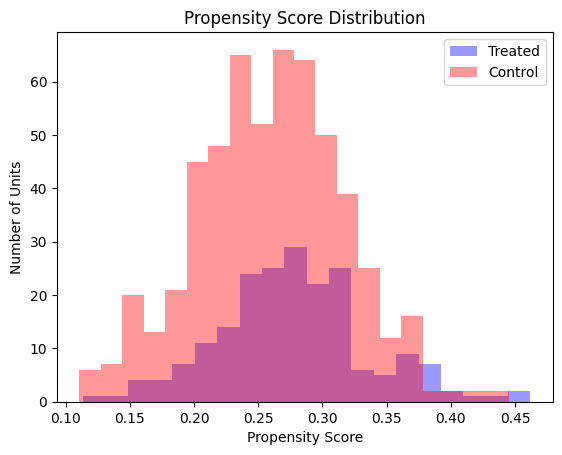


Matching ATE: -0.2622000000000088


In [10]:
print(f"\nMatching ATE: {calc_matching_ATE(X_T, y)}")

**<u>NOTE</u>:**  
1. There is a full distribution overlap.
2. The ATE is negative once again and the difference was greater when matching was based on propensity score only.

# IPW

In [11]:
from sklearn.linear_model import LogisticRegression

def calc_IPW_ATE(X_T, y):
    X_T_copy = X_T.copy()
    propensity_scores = calc_propensity_score(X_T_copy, LogisticRegression(max_iter=300, random_state=11, solver='lbfgs'))
    X_T_copy["propensity_score"] = propensity_scores
    n = len(y)

    # calculating left element of ATE
    treatment_elem = np.sum(y[X_T_copy['had_extreme_weather'] == 1].values / X_T_copy[X_T_copy['had_extreme_weather'] == 1]["propensity_score"].values)

    # calculating right element of ATE
    control_elem = np.sum(y[X_T_copy['had_extreme_weather'] == 0].values / X_T_copy[X_T_copy['had_extreme_weather'] == 0]["propensity_score"].values)

    # calculate ATE
    ATE = (1/n)*(treatment_elem - control_elem)

    return ATE

In [12]:
print(f'IPW ATE: {calc_IPW_ATE(X_T, y)}\n')

IPW ATE: -141342.7809824565



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


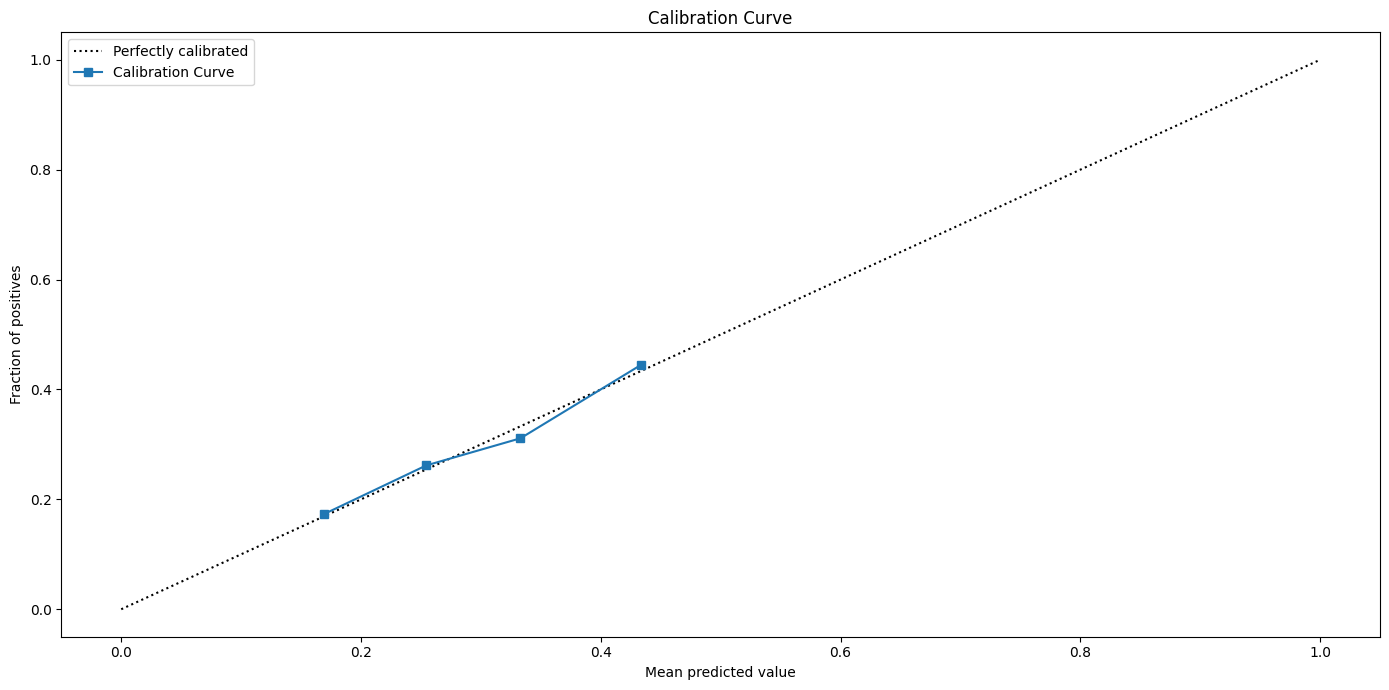

In [17]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(data, title, ax):
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(data['had_extreme_weather'], data['propensity_score'], n_bins=10)

    # Plot calibration curve
    ax.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax.plot(mean_predicted_value, fraction_of_positives, 's-', label=title)
    ax.set_ylabel('Fraction of positives')
    ax.set_xlabel('Mean predicted value')
    ax.set_title(title)
    ax.legend()

X_T_copy = X_T.copy()
propensity_scores = calc_propensity_score(X_T_copy, LogisticRegression(max_iter=300, random_state=11, solver='lbfgs'))
X_T_copy["propensity_score"] = propensity_scores

# Create the figure and axes
fig, axes = plt.subplots(1, 1, figsize=(14, 7))  # 1 row, 2 columns

# Plot calibration curves for both datasets
plot_calibration_curve(X_T_copy, 'Calibration Curve', axes)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()